In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
class Network(nn.Module): # line 1
    def __init__(self):
        super().__init__() # line 3
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [4]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### Training With A Single Batch

In [5]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.299107313156128
loss2: 2.2877957820892334


### Training With All Batches (Single Epoch)

In [6]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader: # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: 47205 loss: 337.94927003979683


### Training With Multiple Epochs

In [7]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 47046 loss: 337.5926354378462
epoch 1 total_correct: 51470 loss: 229.63943175971508
epoch 2 total_correct: 52058 loss: 209.82829378545284
epoch 3 total_correct: 52543 loss: 200.64905054867268
epoch 4 total_correct: 52615 loss: 197.73621214926243
epoch 5 total_correct: 52879 loss: 192.82014168798923
epoch 6 total_correct: 52955 loss: 189.53966110944748
epoch 7 total_correct: 52969 loss: 190.21670903265476
epoch 8 total_correct: 53145 loss: 183.2086077928543
epoch 9 total_correct: 53178 loss: 183.37277787923813


In [15]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [17]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [18]:
preds_correct = get_num_correct(train_preds, train_set.targets)

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Confusion matrix, without normalization
[[5592    9   66   69    8    1  224    0   31    0]
 [  23 5900    1   54    6    1   10    0    5    0]
 [  79    4 4728   61  758    0  343    0   27    0]
 [ 272   32   14 5397  179    1  101    0    3    1]
 [  18   10  284  195 4966    0  505    0   22    0]
 [   1    2    0    2    0 5822    1   75    3   94]
 [1457    9  462  125  344    0 3525    0   77    1]
 [   0    0    0    0    0   81    0 5793    1  125]
 [  23    9   21   17   11   16   18    4 5879    2]
 [   0    0    1    3    0   21    1  179    2 5793]]


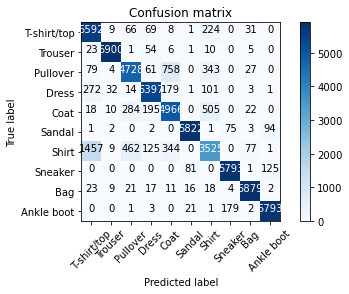